In [1]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import XGBModel
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import matplotlib.pyplot as plt
from darts import concatenate

In [2]:
df = pd.read_csv("../../Data/Kaggle/StoreSales/darts_multivariate.csv", parse_dates=["date"])

In [3]:
df.head()

,date,store_nbr,family,sales,onpromotion,typeholiday,dcoilwtico,city,state,typestores,cluster,day_of_week,day,month,year
0,2013-01-01,8,30,0.0,0,3,93.140000,18,12,3,8,2,1,1,2013
1,2013-01-02,8,30,0.0,0,4,93.140000,18,12,3,8,3,2,1,2013
2,2013-01-03,8,30,0.0,0,4,92.970000,18,12,3,8,4,3,1,2013
3,2013-01-04,8,30,0.0,0,4,93.120000,18,12,3,8,5,4,1,2013
4,2013-01-05,8,30,0.0,0,4,93.159203,18,12,3,8,6,5,1,2013


In [4]:
dcoilwtico_ts = TimeSeries.from_dataframe(df, value_cols=["dcoilwtico"])

In [5]:
onpromotion_ts = TimeSeries.from_dataframe(df, value_cols=["onpromotion"])

In [6]:
typeholiday_ts = TimeSeries.from_dataframe(df, value_cols=["typeholiday"])

In [7]:
day_of_week_ts = TimeSeries.from_dataframe(df, value_cols=["day_of_week"])

In [8]:
day_ts = TimeSeries.from_dataframe(df, value_cols=["day"])

In [9]:
month_ts = TimeSeries.from_dataframe(df, value_cols=["month"])

In [10]:
year_ts = TimeSeries.from_dataframe(df, value_cols=["year"])

In [11]:
future_cov = concatenate([dcoilwtico_ts,
                          onpromotion_ts,
                          typeholiday_ts,
                          day_of_week_ts,
                          day_ts,
                          month_ts,
                          year_ts], axis=1)

In [12]:
ts = TimeSeries.from_dataframe(df, value_cols=["sales"])

In [13]:
training_size = len(ts) - 30

In [14]:
train = ts[:training_size]
val = ts[training_size:]

In [15]:
len_future_covariates = len(val)
future_covariates_lags = list(range(len_future_covariates))

In [16]:
model = XGBModel(lags=2, lags_future_covariates=future_covariates_lags, output_chunk_length=30)
model.fit(train, future_covariates=future_cov)

XGBModel(lags=2, lags_past_covariates=None, lags_future_covariates=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], output_chunk_length=30, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [17]:
predictions = model.predict(n=len(val))

In [18]:
val = val.pd_series().tolist()
predictions = predictions.pd_series().tolist()

In [19]:
predictions = np.maximum(predictions, 0)

In [20]:
rmse = np.sqrt(mean_squared_error(val, predictions))
rmsle = np.sqrt(mean_squared_error(np.log1p(val), np.log1p(predictions)))

In [21]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle}")

Root Mean Squared Error (RMSE): 471.45096677244555
Root Mean Squared Logarithmic Error (RMSLE): 0.10075316677686665


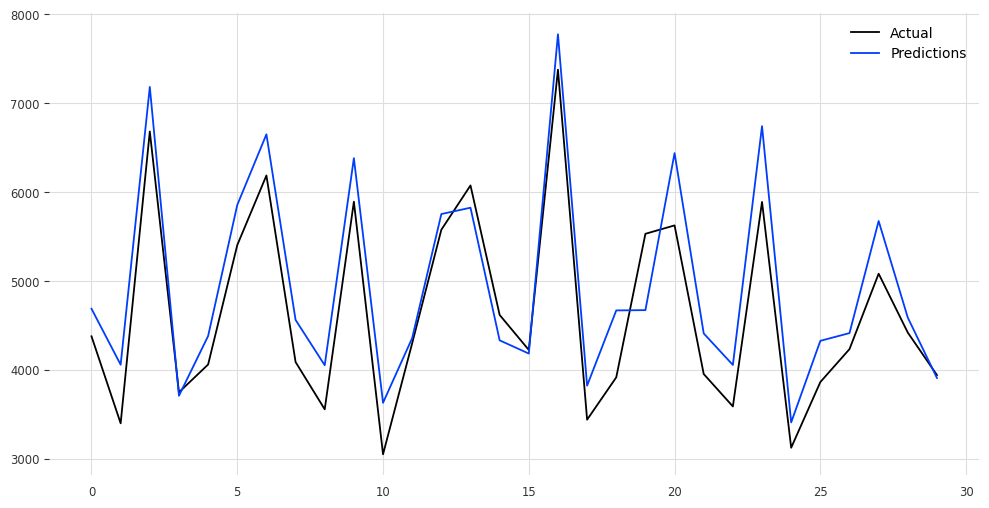

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(val, label='Actual')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()